In [293]:
!pip install ucimlrepo -q


In [365]:
#Numpy, pandasy random
import numpy as np
import pandas as pd
import random

np.random.seed(1) #Semillas fijas
random.seed(1) #Semillas fijas


#Funciones de sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Plots
import matplotlib.pyplot as plt

#Métricas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Datasets
from sklearn.datasets import load_wine
from ucimlrepo import fetch_ucirepo

# Part A

## Features Information

In [295]:
#numeric= 'age', 'trestbp', 'chol', 'thalach', 'oldpeak', 'slope', 'ca'
#categorical = 'sex','cp', 'fbs', 'restecg', 'exang', 'thal'

age: age in years  **(Numeric)**  
sex: sex (1 = male; 0 = female) **(Categorical)**  
cp: chest pain type  **(Categorical)**  

1. Value 1: typical angina  
2. Value 2: atypical angina  
3. Value 3: non-anginal pain  
4. Value 4: asymptomatic  

trestbps: resting blood pressure (in mm Hg on admission to the hospital) **(Numeric)**    
chol: serum cholestoral in mg/dl  **(Numeric)**  
fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false) **(Categorical)**   
restecg: resting electrocardiographic results **(Categorical)**    

1. Value 0: normal  
2. Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)  
3. Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

thalach: maximum heart rate achieved  **(Numeric)**  
exang: exercise induced angina (1 = yes; 0 = no)  **(Categorical)**  
oldpeak = ST depression induced by exercise relative to rest  **(Numeric)**  

slope: the slope of the peak exercise ST segment **(Ordinal/Numeric)**  
1.   upsloping
2.   flat
3.   downsloping

ca: number of major vessels (0-3) colored by flourosopy  **(Numeric)**  
thal: 3 = normal; 6 = fixed defect; 7 = reversable defect  **(Categorical)**  


In [366]:
heart_disease = fetch_ucirepo(id = 45)
X = heart_disease.data.features # Características
Y = heart_disease.data.targets # heart disease diagnosis

In [367]:
Y.value_counts()

,count
num,
0,164
1,55
2,36
3,35
4,13


In [368]:
Y=Y.replace({0:0,1:1,2:1,3:1,4:1})

In [369]:
X.shape

(303, 13)

In [370]:
X.isnull().sum() #Existen pocos nulos

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [371]:
X[(X.ca.isnull()) | (X.thal.isnull())] #Se tratan de filas diferentes, todas

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0


In [372]:
#Partición de los datos
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1) #Se hace la partición 30/70

In [373]:
num_cols = ["age", "trestbps", "chol", "thalach", "oldpeak", "slope", "ca"]
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "thal"]

In [374]:
preprocessor = ColumnTransformer([ #Se realizan pipelines de transformación de columnas
    ("num", Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
    ]), cat_cols)
])

In [375]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'trestbps', 'chol', 'thalach',
                                  'oldpeak', 'slope', 'ca']),
                                ('cat',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                  'thal'])])

In [376]:
X_train=preprocessor.transform(X_train)

In [377]:
X_test=preprocessor.transform(X_test)

## Gradient Descend

In [378]:
def sigmoid(z): #Función sigmoide
    return 1/(1+np.exp(-z))

In [379]:
def cost_function(X, y, beta): #Negative log - likelihood (es la función de costo, lo que se quiere minimizar)
    z = X @ beta
    p = sigmoid(z)
    return -np.mean(y*np.log(p + 1e-9) + (1 - y)*np.log(1 - p + 1e-9))

In [380]:
def gradient(X, y, beta): # Calculo de la gradiente
    p = sigmoid(X @ beta)
    return (X.T @ (p - y)) / len(y)


In [381]:
def gradient_descent(X, y, lr=0.01, n_iter=100000): #Algoritmo de la gradiente descendiente
    #Concatenar columna de 1s
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    beta = np.zeros(X.shape[1])
    cost_history = []
    for _ in range(n_iter):
        cost = cost_function(X, y, beta)
        cost_history.append(cost)
        grad = gradient(X, y, beta)
        beta -= lr * grad
        #Condición de convergencia:
        if len(cost_history) > 1 and np.abs(cost_history[-1] - cost_history[-2]) < 1e-6:
            print(f"Convergencia alcanzada en la iteración {len(cost_history)} con un learning rate de {lr}")
            break
    return beta, cost_history

In [382]:
def predict(X, beta): #Predicción de los betas
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    return (sigmoid(X @ beta) >= 0.5).astype(int)

Convergencia alcanzada en la iteración 3154 con un learning rate de 0.1
Convergencia alcanzada en la iteración 8529 con un learning rate de 0.01
Convergencia alcanzada en la iteración 23998 con un learning rate de 0.001


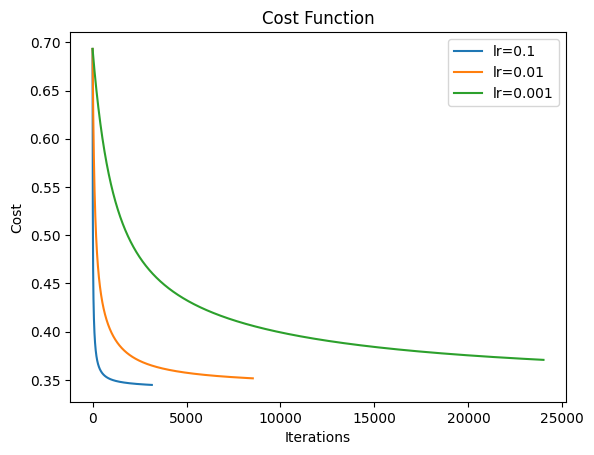

In [383]:
plt.title('Cost Function')
plt.xlabel('Iterations')
plt.ylabel('Cost')
for i in [0.1, 0.01, 0.001]:
  betas_gd, cost_=gradient_descent(X_train,np.ravel(y_train),i)
  plt.plot(cost_, label=f'lr={i}')
plt.legend()
plt.show()


Se puede una convergencia más rápida para el **learning rate** de **0.1**

## Evaluation and Comparison

In [384]:
beta_gd=gradient_descent(X_train,np.ravel(y_train), lr=0.1)
y_predicted=predict(X_test, betas_gd)
print(confusion_matrix(y_test, y_predicted))
print(accuracy_score(y_test, y_predicted))
print(classification_report(y_test,y_predicted))

Convergencia alcanzada en la iteración 3154 con un learning rate de 0.1
[[43  6]
 [ 9 33]]
0.8351648351648352
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        49
           1       0.85      0.79      0.81        42

    accuracy                           0.84        91
   macro avg       0.84      0.83      0.83        91
weighted avg       0.84      0.84      0.83        91



In [385]:
#Regresión Logistica de Sk-learn
mlogistic=LogisticRegression(penalty=None, solver='sag', tol=1e-6)
mlogistic.fit(X_train,np.ravel(y_train))
y_predicted=mlogistic.predict(X_test)
print(confusion_matrix(y_test, y_predicted))
print(accuracy_score(y_test, y_predicted))
print(classification_report(y_test,y_predicted))

[[44  5]
 [ 7 35]]
0.8681318681318682
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        49
           1       0.88      0.83      0.85        42

    accuracy                           0.87        91
   macro avg       0.87      0.87      0.87        91
weighted avg       0.87      0.87      0.87        91



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Los valores se muestran en la comparación de las tablas. El accuracy del modelo de scikit-learn es ligeramente **superior** al obtenido manualmente, con una diferencia aproximada de 0.03. En general, esta tendencia se repite en las demás métricas: **F1-score (0.87 vs 0.83)**, **precision (0.87 vs 0.84)** y **recall (0.87 vs 0.84)**. Se observa, por tanto, que el modelo de scikit-learn realiza predicciones más precisas incluso cuando se emplean hiperparámetros similares.   
Esto ocurre porque los métodos de optimización de sklearn ajustan el tamaño del paso de forma automática, sin usar un learning rate fijo (como SAG, LBFGS o Newton-CG) que ajustan adaptativamente el tamaño del paso de actualización en función de la curvatura del espacio de pérdida, logrando así una convergencia más eficiente y estable.

# Part B

In [386]:
print(load_wine(as_frame=True)['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [387]:
X_wine=load_wine(as_frame=True)['data']

In [388]:
X_wine.isna().sum() #No hay nulos, todo ok

,0
alcohol,0
malic_acid,0
ash,0
alcalinity_of_ash,0
magnesium,0
total_phenols,0
flavanoids,0
nonflavanoid_phenols,0
proanthocyanins,0
color_intensity,0


In [389]:
y_wine=load_wine(as_frame=True)['target']

In [390]:
y_wine.value_counts(dropna=False) #Tipos de vino

,count
target,
1,71
0,59
2,48


In [391]:
X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, test_size=0.3, random_state=1) #Se hace la partición 30/70

In [392]:
standarizer=StandardScaler()
X_train=standarizer.fit_transform(X_train)
X_test=standarizer.transform(X_test)

## OVA Implementation:

In [393]:
def ova_training(X, y, n_iter=100000, lr=0.01):
    betas = []
    for i in range(3):
        y_i = np.where(y == i, 1, 0)
        beta, _ = gradient_descent(X, y_i, n_iter=n_iter, lr=lr)
        betas.append(beta)
    return betas

In [394]:
def ova_predict(X, betas):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    scores = np.array([X @ beta for beta in betas])
    return np.argmax(scores, axis=0)

In [395]:
betas_ova=ova_training(X_train,np.ravel(y_train))

Convergencia alcanzada en la iteración 13072 con un learning rate de 0.01
Convergencia alcanzada en la iteración 18383 con un learning rate de 0.01
Convergencia alcanzada en la iteración 14582 con un learning rate de 0.01


In [396]:
y_predicted_ova=ova_predict(X_test, betas_ova)

In [397]:
# Evaluar OVA Manual
print(confusion_matrix(y_test, y_predicted_ova))
print(accuracy_score(y_test, y_predicted_ova))
print(classification_report(y_test,y_predicted_ova))

[[23  0  0]
 [ 0 19  0]
 [ 0  0 12]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



In [398]:
betas_ova

[array([-2.29690102,  1.61091006,  0.70630365,  1.16481108, -1.501371  ,
         0.06793859,  0.14864237,  1.06062614, -0.2673327 , -0.2919899 ,
        -0.026428  ,  0.26055068,  1.32848233,  2.52837593]),
 array([-1.36516066, -1.89495495, -0.99292186, -1.81901868,  1.00789569,
         0.14274206,  0.18803577,  0.7569608 ,  0.54273123,  0.3356416 ,
        -2.75174061,  1.35484449, -0.01311955, -2.91065969]),
 array([-2.88673936,  0.53541904,  0.52855161,  0.78748364,  0.48130225,
        -0.01428652, -0.22850675, -1.82334878, -0.18869436, -0.51025213,
         2.08507453, -1.32633671, -1.11917884,  0.18886274])]

In [399]:
#Sklearn
model_wine=LogisticRegression(multi_class="ovr", penalty=None, solver='sag', tol=1e-6)
model_wine.fit(X_train,np.ravel(y_train))
y_predicted_sklearn=model_wine.predict(X_test)
print(confusion_matrix(y_test, y_predicted_sklearn))
print(accuracy_score(y_test, y_predicted_sklearn))
print(classification_report(y_test,y_predicted_sklearn))

[[23  0  0]
 [ 0 19  0]
 [ 0  0 12]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [400]:
model_wine.coef_

array([[ 2.78049302,  1.44083115,  2.21237757, -2.94855279,  0.24278874,
         0.0753764 ,  1.94103872, -0.51610519, -0.72280355, -0.18178327,
         0.26325549,  2.73269512,  4.08332204],
       [-2.60004565, -1.62940184, -3.3634019 ,  1.85684646,  0.90926477,
        -0.02863437,  1.70121512,  1.29014091,  0.44642866, -5.49581116,
         2.17525536, -0.20174134, -5.47218899],
       [ 0.92660018,  0.70954387,  1.73580558,  0.55278013, -0.54548195,
         0.45549323, -3.91814221, -0.72011711, -1.15185571,  3.31374955,
        -2.27461005, -1.98300495,  0.79881369]])

In [401]:
#Sklearn (por default)
model_wine=LogisticRegression(multi_class="ovr")
model_wine.fit(X_train,np.ravel(y_train))
y_predicted_sklearn=model_wine.predict(X_test)
print(confusion_matrix(y_test, y_predicted_sklearn))
print(accuracy_score(y_test, y_predicted_sklearn))
print(classification_report(y_test,y_predicted_sklearn))

[[23  0  0]
 [ 0 19  0]
 [ 0  0 12]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [402]:
model_wine.coef_

array([[ 1.19876216,  0.49861341,  0.85995716, -1.09778894,  0.1426412 ,
         0.19562955,  0.82653339, -0.29391332, -0.201802  , -0.06431   ,
         0.24362507,  0.97759831,  1.82136133],
       [-1.29266825, -0.69681691, -1.1313864 ,  0.63022357, -0.0076299 ,
         0.1293651 ,  0.53496196,  0.29520228,  0.22205625, -1.82142839,
         0.78530983, -0.01399813, -1.83103932],
       [ 0.38206358,  0.50849781,  0.59338528,  0.381929  ,  0.04250663,
        -0.34389729, -1.46104549,  0.05662405, -0.65974282,  1.1853721 ,
        -1.11532205, -0.98533547,  0.17711464]])

En este experimento se utilizaron tres clasificadores. El primero fue un modelo **One-vs-All** implementado manualmente, basado en el algoritmo desarrollado en la parte A. El segundo correspondió al **One-vs-All de *scikit-learn*** configurado con hiperparámetros similares al modelo manual, mientras que el tercero empleó la configuración **predeterminada** de *scikit-learn*.

Los resultados muestran que todos los modelos obtuvieron un *accuracy* global perfecto (**1.0**). Los coeficientes del modelo predeterminado presentan valores absolutos relativamente menores, lo que indica un efecto de regularización que podría contribuir a mejorar la generalización del modelo.

# Part C
Multinomial (Softmax) Logistic Regression from Scratch

We again maximize likelihood over a dataset  $\mathcal{D}$.
\begin{align*}
L(\theta) & = \prod_{i=1}^n P_\theta (y^{(i)} \mid x^{(i)}) = \prod_{i=1}^n \vec \sigma(\vec z^{(i)})_{y^{(i)}} \\
& = \prod_{i=1}^n \left( \frac{\exp(\theta_{y^{(i)}}^\top x^{(i)})}{\sum_{l=1}^K \exp(\theta_l^\top x^{(i)})} \right).
\end{align*}

We optimize this using gradient descent on the **log-likelihood $\ell(\theta)$**, which has the form.
\begin{align*}
\ell(\theta)=\log[L(\theta)]=\sum_{i=1}^n\theta_{y^{(i)}}^\top x^{(i)}-\sum_{i=1}^n\log\left[\sum_{j=1}^K\exp(\theta_j^\top x^{(i)})\right].
\end{align*}

Let us define:
\begin{align*}
a &= \sum_{i=1}^n \theta_{y^{(i)}}^\top x^{(i)}, \\
b &= \sum_{i=1}^n \log \left( \sum_{j=1}^K \exp(\theta_j^\top x^{(i)}) \right),
\end{align*}
so that $\ell(\theta) = a - b$.

---

### Derivative of $a$ with respect to $\theta_l$
\begin{align*}
\frac{\partial a}{\partial \theta_l}
&= \sum_{i=1}^n \frac{\partial}{\partial \theta_l}\big(\theta_{y^{(i)}}^\top x^{(i)}\big)
= \sum_{i=1}^n \mathbf{1}\{y^{(i)} = l\} \, x^{(i)}.
\end{align*}

### Derivative of $b$ with respect to $\theta_l$
\begin{align*}
\frac{\partial b}{\partial \theta_l}
&= \sum_{i=1}^n
\frac{1}{\sum_{j=1}^K \exp(\theta_j^\top x^{(i)})}
\cdot
\frac{\partial}{\partial \theta_l}
\left(\sum_{j=1}^K \exp(\theta_j^\top x^{(i)})\right) \\
&= \sum_{i=1}^n
\frac{\exp(\theta_l^\top x^{(i)})}{\sum_{j=1}^K \exp(\theta_j^\top x^{(i)})}
\, x^{(i)} \\
&= \sum_{i=1}^n
\sigma(\mathbf{z}^{(i)})_l \, x^{(i)},
\end{align*}
where $\sigma(\mathbf{z}^{(i)})_l = P_\theta(y=l \mid x^{(i)})$.

---

### Gradient of the log-likelihood
\begin{align*}
\frac{\partial \ell(\theta)}{\partial \theta_l}
&= \frac{\partial a}{\partial \theta_l} - \frac{\partial b}{\partial \theta_l} \\
&= \sum_{i=1}^n
\left[\mathbf{1}\{y^{(i)} = l\} - \sigma(\mathbf{z}^{(i)})_l\right]
x^{(i)}
\end{align*}

Implementation:

In [413]:
def softmax(z): # Función softmax (con estabilidad numérica)
    z -= np.max(z, axis=1, keepdims=True)       # Mejora la estabilidad numérica
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [414]:
def cost_function_softmax(X, y, beta): # Negative log-likelihood (función de costo a minimizar)
    n = len(y)
    z = X @ beta
    z -= np.max(z, axis=1, keepdims=True)       # Corrección numérica
    exp_z = np.exp(z)
    sum_exp_z = np.sum(exp_z, axis=1, keepdims=True)
    p = exp_z / sum_exp_z                       # Probabilidades predichas
    y_one_hot = np.eye(p.shape[1])[y]           # Representación one-hot de las clases verdaderas
    log_likelihood = np.sum(y_one_hot * z - np.log(sum_exp_z)) / n
    return -log_likelihood                      # Se devuelve el negativo (para minimizar)

In [415]:
def gradient_softmax(X, y, beta): # Cálculo de la gradiente
    n = len(y)
    p = softmax(X @ beta)
    y_one_hot = np.eye(p.shape[1])[y]           # Matriz one-hot
    grad = (X.T @ (p - y_one_hot)) / n
    return grad

In [416]:
def softmax_gradient_descent(X, y, lr=0.01, n_iter=100000, tol=1e-6): # Algoritmo de la gradiente descendiente para softmax
    n_classes = np.unique(y).shape[0]
    X=np.hstack((np.ones((X.shape[0], 1)), X))
    beta = np.zeros((X.shape[1], n_classes))    # Inicialización de los parámetros
    cost_history = []

    for i in range(n_iter):
        cost = cost_function_softmax(X, y, beta)
        cost_history.append(cost)
        grad = gradient_softmax(X, y, beta)
        beta -= lr * grad   # Actualización simultánea de todos los vectores de pesos

        # Condición de convergencia
        if i > 1 and np.abs(cost_history[-1] - cost_history[-2]) < tol:
            print(f"Convergencia alcanzada en la iteración {i} con un learning rate de {lr}")
            break

    return beta, cost_history

In [417]:
def predict_softmax(X, beta): # Predicción de los betas
    X=np.hstack((np.ones((X.shape[0], 1)), X))
    return np.argmax(softmax(X @ beta), axis=1)

Convergencia alcanzada en la iteración 9709 con un learning rate de 0.1
Convergencia alcanzada en la iteración 26613 con un learning rate de 0.01
Convergencia alcanzada en la iteración 63395 con un learning rate de 0.001


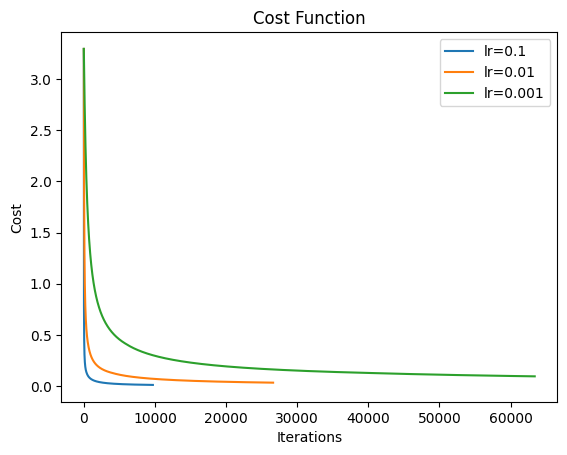

In [418]:
plt.title('Cost Function')
plt.xlabel('Iterations')
plt.ylabel('Cost')
for i in [0.1, 0.01, 0.001]:
  betas_softmax, cost_=softmax_gradient_descent(X_train,np.ravel(y_train),i)
  plt.plot(cost_, label=f'lr={i}')
plt.legend()
plt.show()

En comparación con el enfoque **One-vs-All**, el modelo **multinomial (softmax)** alcanza la convergencia con una **menor cantidad total de iteraciones** (26613  frente a 13 072 + 18 383 + 14 582 en OvA). Esto se debe a que, al actualizar simultáneamente todos los vectores de pesos, el algoritmo aprovecha mejor la información compartida entre clases, evitando redundancias en el cálculo de los gradientes.

Además, se observa que **un mayor *learning rate*** permite alcanzar la convergencia en un **menor número de iteraciones**, aunque con el riesgo potencial de **oscilaciones** si el paso es demasiado grande. En este experimento, los valores de lr = 0.1, 0.01 y 0.001 muestran curvas de costo descendentes estables, con una convergencia más rápida para tasas de aprendizaje más altas.


## Evaluation and Comparison

In [419]:
#Usando all vs one
betas_ova=ova_training(X_train,np.ravel(y_train))
y_predicted_ova=ova_predict(X_test, betas_ova)
print(confusion_matrix(y_test, y_predicted_ova))
print(accuracy_score(y_test, y_predicted_ova))
print(classification_report(y_test,y_predicted_ova))

Convergencia alcanzada en la iteración 13072 con un learning rate de 0.01
Convergencia alcanzada en la iteración 18383 con un learning rate de 0.01
Convergencia alcanzada en la iteración 14582 con un learning rate de 0.01
[[23  0  0]
 [ 0 19  0]
 [ 0  0 12]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



In [420]:
#Softmax implementado
betas_softmax, cost_=softmax_gradient_descent(X_train,np.ravel(y_train))
y_predicted_softmax=predict_softmax(X_test, betas_softmax)
print(confusion_matrix(y_test, y_predicted_softmax))
print(accuracy_score(y_test, y_predicted_softmax))
print(classification_report(y_test,y_predicted_softmax))

Convergencia alcanzada en la iteración 26613 con un learning rate de 0.01
[[23  0  0]
 [ 0 19  0]
 [ 0  0 12]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



In [421]:
#Usando sklearn ova
model_wine=LogisticRegression(multi_class='ovr')
model_wine.fit(X_train,np.ravel(y_train))
y_predicted_sklearn=model_wine.predict(X_test)
print(confusion_matrix(y_test, y_predicted_sklearn))
print(accuracy_score(y_test, y_predicted_sklearn))
print(classification_report(y_test,y_predicted_sklearn))

[[23  0  0]
 [ 0 19  0]
 [ 0  0 12]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [422]:
#Usando sklearn multinomial
model_wine=LogisticRegression(multi_class="multinomial", solver='lbfgs')
model_wine.fit(X_train,np.ravel(y_train))
y_predicted_sklearn=model_wine.predict(X_test)
print(confusion_matrix(y_test, y_predicted_sklearn))
print(accuracy_score(y_test, y_predicted_sklearn))
print(classification_report(y_test,y_predicted_sklearn))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[[23  0  0]
 [ 0 19  0]
 [ 0  0 12]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



En los experimentos realizados, todos los modelos alcanzaron una **clasificación correcta y sin errores**, lo que sugiere que, más allá de las posibles diferencias en efectividad entre el enfoque **softmax multinomial** y el enfoque **One-vs-All**, la principal ventaja práctica del primero radica en su **mayor eficiencia computacional**. Al actualizar simultáneamente todos los vectores de pesos, el modelo softmax reduce la redundancia en los cálculos y acelera el proceso de convergencia sin comprometer el desempeño predictivo.